[View in Colaboratory](https://colab.research.google.com/github/MahmoudFarouq/DLmodels/blob/master/ResNet.ipynb)

In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [0]:
def resNetBlock_Identity(X, f, filters, stage, block):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  return X

In [3]:
import tensorflow as tf

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = resNetBlock_Identity(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.19716819 0.         1.3561226  2.1713073  0.         1.3324987 ]


In [0]:
def resNetBlock_convolutional(X, f, filters, stage, block, s=2):
  
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'
  
  F1, F2, F3 = filters
  short_cut = X
  
  X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same' , name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
  X = Activation('relu')(X)
  
  X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='same', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
  
  short_cut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid' , name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(short_cut)
  short_cut = BatchNormalization(axis = 3, name = bn_name_base + '1')(short_cut)
  
  X = Add()([X, short_cut])
  X = Activation('relu')(X)
  return X

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_prev = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = resNetBlock_convolutional(A_prev, f = 2, filters = [2, 4, 6], stage = 1, block = 'a')
    test.run(tf.global_variables_initializer())
    out = test.run([A], feed_dict={A_prev: X, K.learning_phase(): 0})
    print("out = " + str(out[0][1][1][0]))

out = [0.09018462 1.2348977  0.46822017 0.03671761 0.         0.65516603]


In [0]:
def ResNet50(input_shape=(64, 64, 3), classes=6):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = resNetBlock_convolutional(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='b')
    X = resNetBlock_Identity(X, 3, [64, 64, 256], stage=2, block='c')

    X = resNetBlock_convolutional(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='b')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='c')
    X = resNetBlock_Identity(X, 3, [128, 128, 512], stage=3, block='d')

    X = resNetBlock_convolutional(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='b')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='c')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='d')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='e')
    X = resNetBlock_Identity(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = resNetBlock_convolutional(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='b')
    X = resNetBlock_Identity(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    
    return model

In [0]:
model = ResNet50(input_shape = (28, 28, 1), classes = 10)

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [0]:
X_train = mnist.train.images.reshape(-1, 28, 28, 1)
y_train = mnist.train.labels

X_test = mnist.test.images.reshape(-1, 28, 28, 1)
y_test = mnist.test.labels

In [11]:
model.fit(X_train, y_train, epochs = 2, batch_size = 32)

Epoch 1/2
55000/55000 [==============================] - 448s 8ms/step - loss: 0.6093 - acc: 0.8512


Epoch 2/2
55000/55000 [==============================] - 421s 8ms/step - loss: 0.7901 - acc: 0.8526


In [13]:
preds = model.evaluate(X_test[:1000], y_test[:1000])
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

1000/1000 [==============================] - 3s 3ms/step
Loss = 0.6601145310401917
Test Accuracy = 0.898


In [0]:
import matplotlib.pyplot as plt
test_batch = mnist.test.next_batch(200)
def Test(index):
  testImg  = test_batch[0][index].reshape(1, 28, 28, 1)
  testImgL = test_batch[1][index].reshape(1, 10)
  res = model.predict(testImg)
  print(type(res))
  print("predicted: %f"%res.argmax(axis=1))
  plt.imshow(testImg.reshape(28, 28))
  plt.show()

<class 'numpy.ndarray'>
predicted: 5.000000


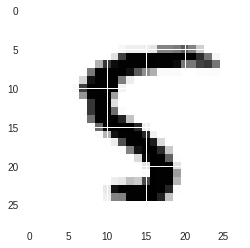

In [27]:
Test(48)

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 34, 34, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 14, 14, 64)   3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 14, 14, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation